# Downside Risk Measures

Some people and professionals argue that the risk is not really the volatility of the returns, but the probability and magnitude of the negative returns. Based on that, we will show today some popular ways that are used to measure this kind of risk.

### Always Starting with the Libraries and Data

Remember that this analysis can be used with any asset or portfolio.

<AxesSubplot:xlabel='Date'>

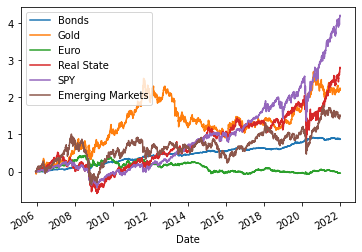

In [79]:
import yfinance as yf
import pandas as pd
import numpy as np

#Defining two lists, one with the tickers and the other with class name
tickers = ["AGG", 'GLD', "FXE",'VNQ', 'IVV', 'VWO']
class_ = ["Bonds", 'Gold', 'Euro', 'Real State', 'SPY', "Emerging Markets"]

#We will save the returns in this list
hist_returns = []

for asset in tickers:
    #We save the time series prices here (the maximum information available) 
    security = yf.Ticker(asset).history(period="max")
    #We calculate the returns
    returns = security['Close'].pct_change().dropna()
    #We save the results in the list
    hist_returns.append(returns)

#We transform the list with returns in a data frame object
data = pd.concat(hist_returns, 1)
#We get only the dates where all etfs were available
data = data.dropna()
#We nominated the columns
data.columns = class_

#Calculating the acumulated returns using ln
np.expm1(np.log1p(data).cumsum()).plot()

### SemiDeviation

It is the volatility of the negative returns.

In [80]:
def semideviation(r):
    '''
    Returns the SemiDeviation of the given returns
    And returns it in anual base.
    '''
    is_negative = r < 0
    return r[is_negative].std(ddof=0)*(365**0.5)

semideviation(data)

Bonds               0.053313
Gold                0.165177
Euro                0.074420
Real State          0.310267
SPY                 0.198155
Emerging Markets    0.261706
dtype: float64

### VaR

We choose a level of risk, for example 5%, and we calculate what are the returns that fall below this level. So we get a percentile.

In [81]:
def var_historic(r, level=5):
    """
    Returns the Historic Value at Risk for a given level (0 < level < 1).
    """
    if isinstance(r, pd.DataFrame):
        return r.aggregate(var_historic, level=level)
    elif isinstance(r, pd.Series):
        return -np.percentile(r, level)
    else:
        raise TypeError("Expected r to be a Series or DataFrame") 
        
var_historic(data, 1)

Bonds               0.006747
Gold                0.031971
Euro                0.015079
Real State          0.061579
SPY                 0.036802
Emerging Markets    0.051527
dtype: float64

### CVaR

This is the Conditional Value at Risk, it returns the mean of the returns that fall bellow the VaR.

In [82]:
def cvar_historic(r, level=5):
    """
    Returns the Conditional Historic Value at Risk for a given level (0 < level < 1).
    """
    if isinstance(r, pd.DataFrame):
        return r.aggregate(cvar_historic, level=level)
    elif isinstance(r, pd.Series):
        var = -np.percentile(r, level)
        index = r <= -var
        return -r[index].mean()
    else:
        raise TypeError("Expected r to be a Series or DataFrame") 

cvar_historic(data, 1)

Bonds               0.013317
Gold                0.044436
Euro                0.019147
Real State          0.089604
SPY                 0.053906
Emerging Markets    0.074259
dtype: float64

### Parametric Gaussian Var

Here we assume that the returns are normally distributed, and based in that and in a level of risk, we compute the returns that will fall below that level.

In [85]:
def var_gaussian(r, level=5):
    """
    Returns the Parametric Gauusian VaR of a Series or DataFrame
    """
    #We will use this library to get our z value
    from scipy.stats import norm
    
    #Getting the z value
    z = norm.ppf(level/100)
    
    return -(r.mean() + z*r.std(ddof=0))

var_gaussian(data, 1)

Bonds               0.007103
Gold                0.026483
Euro                0.013390
Real State          0.045083
SPY                 0.028185
Emerging Markets    0.041099
dtype: float64

### Cornish-Fisher Modification

This is a very nice modification where they use the kurtosis and skewness of the returns to adjust the Parametric VaR.

In [86]:
def var_gaussian(r, level=5, modified = False):
    """
    Returns the Parametric Gauusian VaR of a Series or DataFrame
    """
    #We will use this library to get our z value
    from scipy.stats import norm
    import scipy.stats as stat

    #Getting the z value
    z = norm.ppf(level/100)
    
    if isinstance(r, pd.DataFrame):
        return r.aggregate(var_gaussian, level=level, modified = modified)
    elif isinstance(r, pd.Series):
        if modified:
            # modify the Z score based on observed skewness and kurtosis
            s = stat.skew(r)
            k = stat.kurtosis(r) 
            z = (z +
                    (z**2 - 1)*s/6 +
                    (z**3 -3*z)*(k)/24 -
                    (2*z**3 - 5*z)*(s**2)/36
                )
        return -(r.mean() + z*r.std(ddof=0))
    else:
        raise TypeError("Expected r to be a Series or DataFrame") 

var_gaussian(data, 1, modified = True)

Bonds               0.063718
Gold                0.044881
Euro                0.016813
Real State          0.119048
SPY                 0.067355
Emerging Markets    0.096132
dtype: float64

### Comparing the different metrics

In [96]:
metrics = [var_gaussian(data, 1, modified = True), var_gaussian(data, 1), var_historic(data, 1), cvar_historic(data, 1)]
df = pd.concat(metrics, axis = 1)
df.columns = ['Cornish-Fisher', 'Parametric', 'Historic', 'Conditional']
df

,Cornish-Fisher,Parametric,Historic,Conditional
Bonds,0.063718,0.007103,0.006747,0.013317
Gold,0.044881,0.026483,0.031971,0.044436
Euro,0.016813,0.013390,0.015079,0.019147
Real State,0.119048,0.045083,0.061579,0.089604
SPY,0.067355,0.028185,0.036802,0.053906
Emerging Markets,0.096132,0.041099,0.051527,0.074259


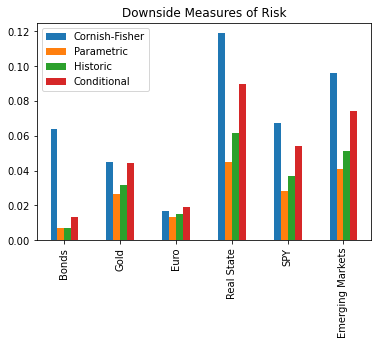

In [101]:
plot = df.plot.bar(title = 'Downside Measures of Risk')
fig = plot.get_figure()
fig.savefig('Plot.png')